In [121]:
import numpy as np
import numpy.linalg as lin
import pandas as pd
import matplotlib.pyplot as plt
import gpflow
import tensorflow as tf
import IPython.display as ipd
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.metrics
import collections
import itertools
import datetime
import logging

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def showHTML(x):
    ipd.display(ipd.HTML(x))

def hideInput():
    showHTML(r'''<script>if(window.$)$(document.currentScript).parents('div.code_cell').find('div.input').hide()</script>''')
    
logging.disable(logging.WARN)

# Dataset

* O conjunto de dados analisados é contém o número de passageiros em vôos internacionais. 
* O dataset é composto por duas colunas, a primeira com datas (mês e ano) e a segunda o número de passageiros que voaram no período em milhares
* O dataset contém 144 entradas no período entre janeiro de 1949 e dezembro de 1960.
* Os dados foram obitidos da [Time Series Data Library](https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60)


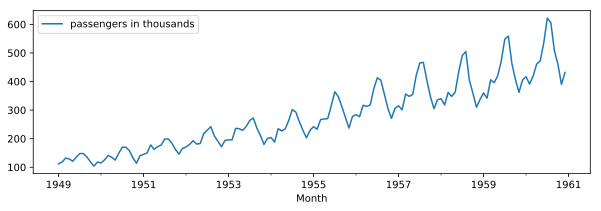

In [53]:
hideInput()
Y = pd.read_csv("international-airline-passengers.csv")
Y['Month'] = pd.to_datetime(Y['Month'])
Y = Y.sort_values('Month').set_index('Month')
Y['passengers in thousands'] = Y['passengers in thousands'].astype(float)
t = Y.index
Y.plot.line(figsize=(10,3));

In [30]:
def lag_dataframe(d,i):
    if i == 0:
        return d
    else:
        return d.shift(i).rename(lambda c: f'{c}_lag{i}', axis='columns')

def add_lag(lag,*data):
    return pd.concat([
        lag_dataframe(x,i) for x in data for i in range(0,lag+1)
    ], axis=1)
    
def plot(ax, t, mean, var=None, label=None, color='C0'):
    ax.plot(t, mean, color=color, lw=2, label=label)
    if (var is not None):
        ax.fill_between(t, mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color=color, alpha=0.2)

# Médias Móveis
Na estimativa por médias móveis consideramos a média das últimas $k$ amostras ($t-1, t-2, ..., t-k$) como a predição para o tempo $t$.

Aqui iremos usar $k = 4$, ou seja, os últimos quatro meses de observações.

In [56]:
k = 4
X = add_lag(k,Y)
mm = X.iloc[:,1:].mean(axis=1)

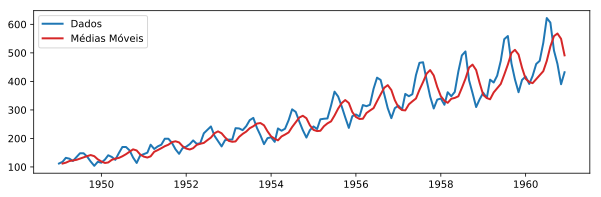

In [66]:
f,ax = plt.subplots(figsize=(10,3))
plot(ax, t, Y, label="Dados")
plot(ax, t, mm, label="Médias Móveis", color='C3')
plt.legend()
hideInput()

# Dynamic Linear Model

Para fazer a predição usando DLM foi utilizado o código fornecido em sala de aula com parâmetros:

<div style="">   

$$\begin{align*}
G &= \begin{pmatrix}1 & 1 \\ 0 & 1\end{pmatrix},&
F &= \begin{pmatrix}1\\ 0\end{pmatrix},&
W &= \begin{pmatrix}100 & 0\\ 0 & 10\end{pmatrix}\\
V &= \begin{pmatrix}100\end{pmatrix},&
m_0 &= \begin{pmatrix}100 \\ 10\end{pmatrix},&
C_0 &= \begin{pmatrix}100 & 0 \\ 0 & 100\end{pmatrix}&
\end{align*}$$
</div>

In [69]:
def dlm(m0, C0, G, F, W, V, Y):
    T = Y.shape[1]
    
    m = m0
    C = C0
    
    m_list = np.zeros((T,m0.shape[0]))
    f_list = np.zeros(T)
    
    for t in range(T):
        
        y = Y[:,t]
        
        ##Parametros da priori de teta
        a = G.dot(m)
        R = G.dot(C).dot(G.T)+W
        
        ##Parametros da preditiva de y        
        f = F.dot(a)
        Q = F.dot(R).dot(F.T)+V
        
        ##Parametros da posteriori
        A_t = lin.solve(Q, F.dot(R))
        A = A_t.T
        
        m = a+A.dot(y-f)
        C = R-A.dot(Q).dot(A.T)
        
        m_list[t] = m.reshape(-1)
        f_list[t] = f
        
        
    return f_list, m_list

In [80]:
G = np.array ([[1,1],[0,1]]);F = np.array([[1, 0]])
W = np.diag([1e2, 1e1]);V = np.diag([1e2])
m0 = np.array([[1e2],[1e1]]);C0 = np.diag([1e2, 1e2])

In [82]:
dlm_y, dlm_f = dlm(m0, C0, G, F, W, V, Y.values.reshape((1,-1)))

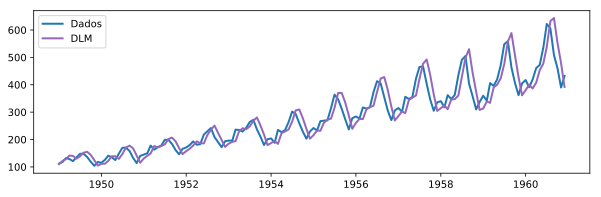

In [86]:
f,ax = plt.subplots(figsize=(10,3))
plot(ax, t, Y, label="Dados")
plot(ax, t, dlm_y, label="DLM", color='C4')
plt.legend()
hideInput()

# Modelo Autoregressivo Não-linear (NAR)

Dado um modelo $\phi$, podemos criar um modelo o modelo:

$$AR_\phi(t+1) = \phi\left([y_{t},y_{t-1},\ldots,y_{t-k-1}]\right)$$

Ou seja, dado um modelo de regressão qualquer, iremos alimentar ele com uma janela de $k$ saídas passadas e usar a saída desse modelo como previsão para o tempo atual.

# Processo Gaussianos (GP)
Um Processo Gaussiano é uma distribuição de probabilidade $p(f)$, onde $f : \mathbb{R}^D\rightarrow\mathbb{R}$.

Seja $\mathbf{f} = [f(x_1), f(x_2),\ldots,f(x_n)]$ tal que $x_i \in \mathbb{R}^D$, perceba que $\mathbf{f}$ é uma variável aleatória. Os parametros que definem um Processo Gaussiano são tais que:
* Uma função de média $\mu(x)$, tal que:<br>$$\mathbb{E}(\mathbf{f}) = [\mu(x_1), \mu(x_2),\ldots,\mu(x_n)] = \mathbf{m}$$<br>
* Uma função de kernel $k(x,y)$, tal que:<br>$$p(\mathbf{f}) \sim \mathcal{N}(\mathbf{m}, \mathbf{K}) \\ \mathbf{K}_{ij} = k(x_i,x_j)$$

O procedimento de regressão consiste em montar o seguinte modelo Bayesiano:

$$\begin{align*}
f &\sim \mathcal{GP}(\mu,k) \\
y(x) &\sim \mathcal{N}(f(x), \varepsilon)
\end{align*}$$

O modelo que usamos nas previsões é a posteriori $p(f\mid \mathcal{D})$ onde $\mathcal{D} = \{(x_i,y_i)\}$ são as nossas observações.

![](https://i.stack.imgur.com/Lru5X.png)

# GP-NAR

Para usar Processos Gaussiano na tarefa de previsão de séries temporais iremos usar a abordagem do NAR sendo $\phi$ um GP. Assim, usamos:

* $k=4$ que nem na Média Móvel;
* Os primeiros $12\cdot4$ meses como conjunto de treino;
* Função de média linear, $\mu(x) = \mathbf{A}x+b$, onde $\{\mathbf{A}, b\}$ são hiperparametros.
* Função de kernel RBF, $k(x,y) = \sigma\cdot\mathrm{exp}\left[-\frac{1}{2}\sum_d w_d(x_{d}-y_{d})^2\right]$ onde $\{\sigma, w\}$ são hiperparametros.

Para escolher os valores dos hiperparametros, fizemos o procedimento usual com modelagem por GP que é otimizar $\{\mathbf{A}, b, \sigma, w\}$ de tal forma que a verossimilhança do modelo é máxima.

In [89]:
train_size = 12*4
X_train = X.iloc[k:train_size].values
y_train = Y.iloc[k+1:train_size+1].values

mu = gpflow.mean_functions.Linear(np.random.rand(X.shape[1],1), 0.01)
k = gpflow.kernels.RBF(X.shape[1], ARD=True)
GP_NAR = gpflow.models.GPR(X_train, y_train, k, mu)

In [109]:
tf.logging.set_verbosity(tf.logging.ERROR)
gpflow.train.ScipyOptimizer().minimize(GP_NAR)
tf.logging.set_verbosity(tf.logging.INFO)

In [122]:
gp_y, gp_f = GP_NAR.predict_y(X), GP_NAR.predict_f(X)

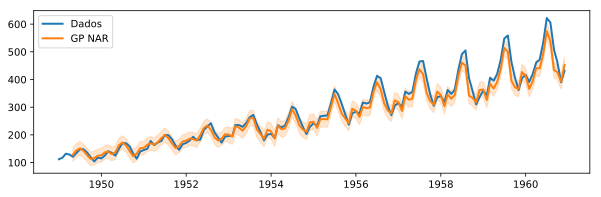

In [114]:
f,ax = plt.subplots(figsize=(10,3))
plot(ax, t, Y, label="Dados")
plot(ax, t, *gp_y, label="GP NAR", color='C1')
plt.legend()
hideInput()

# Comparação dos modelos

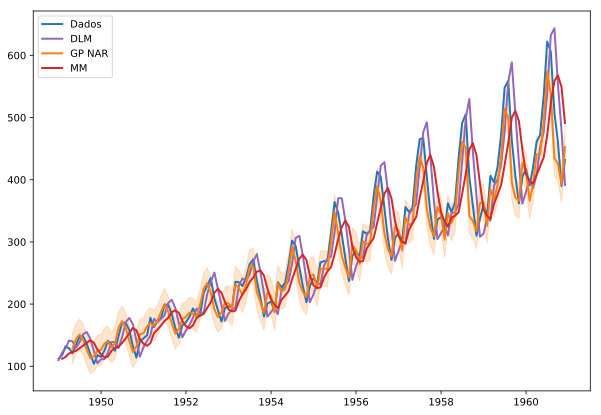

In [125]:
f,ax = plt.subplots(figsize=(10,7))
plot(ax, t, Y, label="Dados")
plot(ax, t, dlm_y, label= "DLM", color='C4')
plot(ax, t, *gp_y, label="GP NAR", color='C1')
plot(ax, t, mm, label="MM", color='C3')
plt.legend()
hideInput()

# Comparação dos modelos

In [139]:
hideInput()
pd.DataFrame([
    sk.metrics.mean_squared_error(y_true=Y[train_size:], y_pred=dlm_y[train_size:]),
    sk.metrics.mean_squared_error(y_true=Y[train_size:], y_pred=mm[train_size:]),
    sk.metrics.mean_squared_error(y_true=Y[train_size:], y_pred=gp_y[0][train_size:])
], index=['Dynamic Linear Model','Média Móveis','GP-NAR']).sort_values(by=0).rename(columns={0:'Erro Quadrático Médio'})

,Erro Quadrático Médio
GP-NAR,682.430239
Dynamic Linear Model,2416.127291
Média Móveis,3796.095703
